<a href="https://colab.research.google.com/github/ajaynain-eng/Car-Damage-Detection/blob/main/CarDamageDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
 import os
 os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/'

In [2]:
!kaggle datasets download -d anujms/car-damage-detection

 95% 117M/123M [00:01<00:00, 87.9MB/s] 
100% 123M/123M [00:01<00:00, 86.8MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [ ]:
!pip install tensorflow-gpu

####Importing required modules

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import time

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, Conv2D, Conv2DTranspose, Flatten, Dense, BatchNormalization, Dropout, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

####making use of gpu if available

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

####Loading the data

In [28]:
base_dir = '/content/data1a'
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

In [29]:
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

####Data visualization

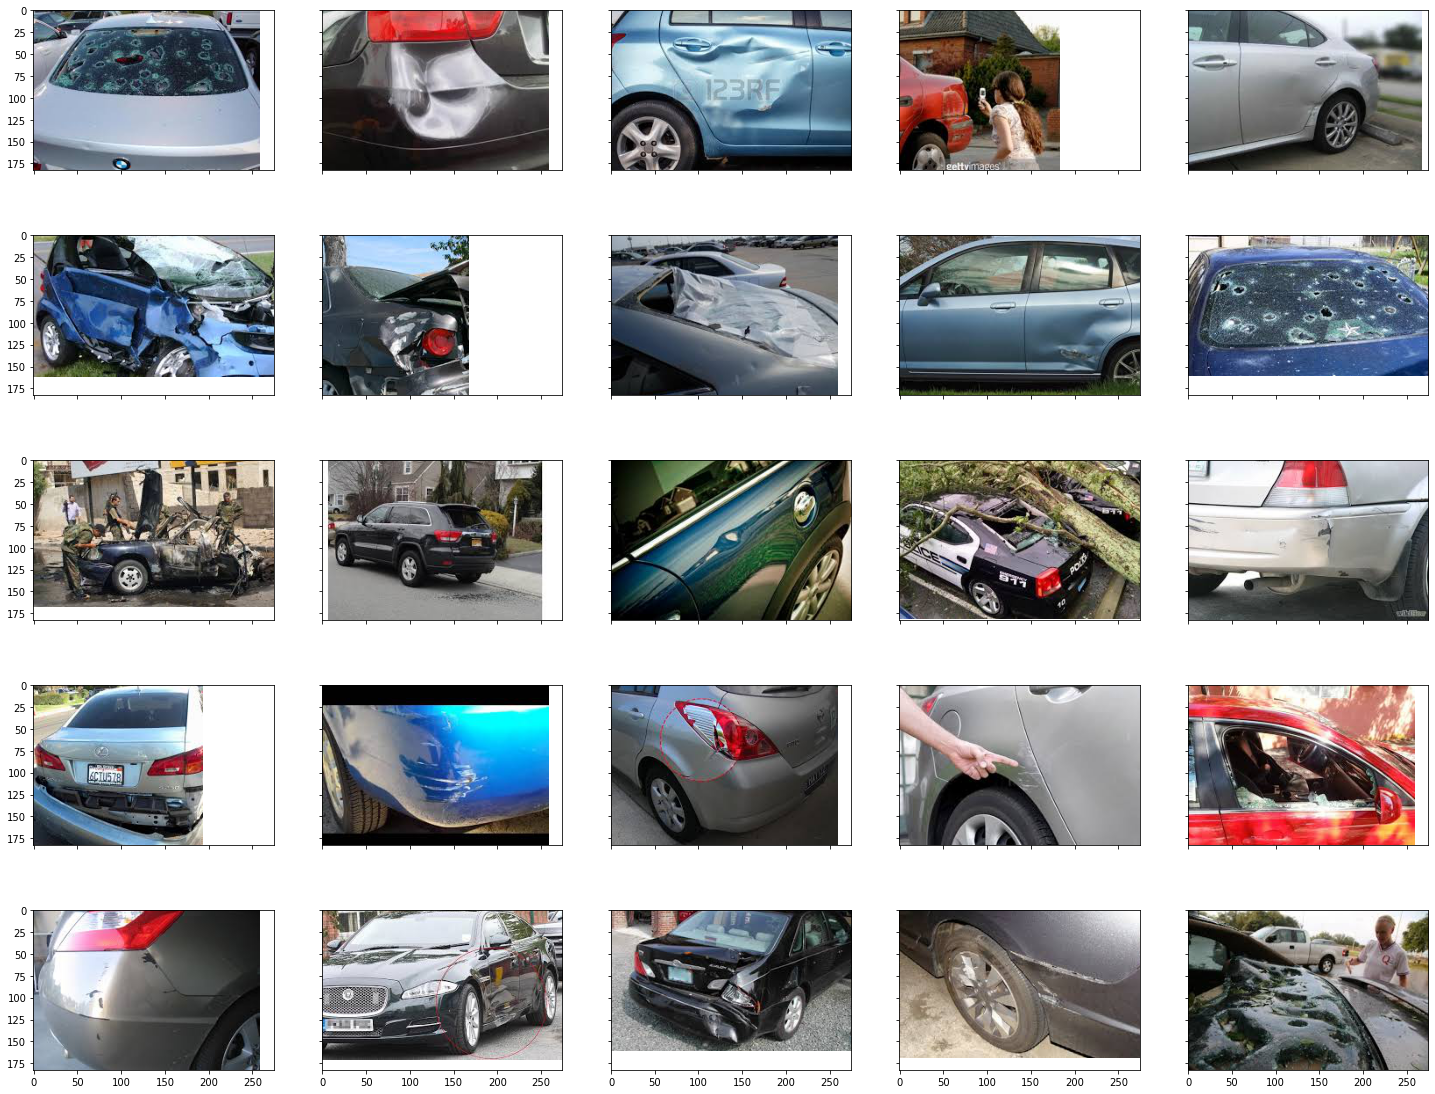

In [33]:
imgs_base_path = '/content/data1a/training/00-damage/'
imgs = os.listdir(imgs_base_path)
imgs.sort()
fig, axe = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True, figsize = (25,20))
for i in range(5):
    for j in range(5):
        s = 5*i + j + 10
        img_path = os.path.join(imgs_base_path, imgs[s])
        img = plt.imread(img_path)
        axe[i,j].imshow(img)

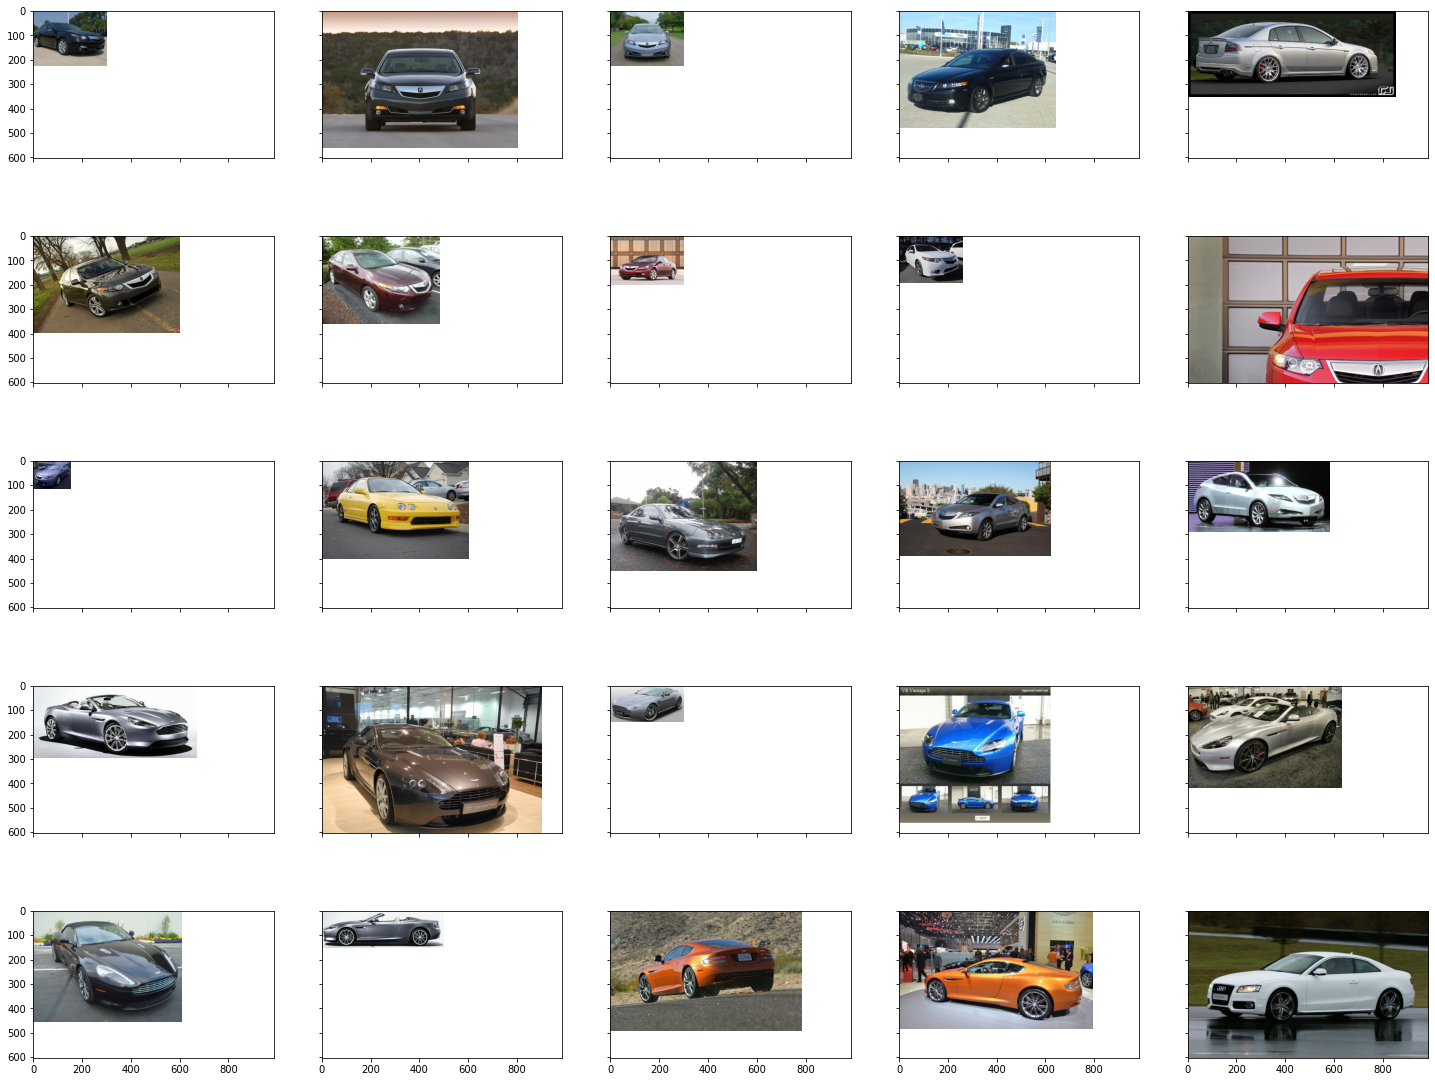

In [34]:
imgs_base_path_1 = '/content/data1a/training/01-whole/'
imgs_1 = os.listdir(imgs_base_path_1)
imgs_1.sort()
fig, axe = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True, figsize = (25,20))
for i in range(5):
    for j in range(5):
        s = 5*i + j + 10
        img_path = os.path.join(imgs_base_path_1, imgs_1[s])
        img = plt.imread(img_path)
        axe[i,j].imshow(img)

#####Some images are very small as compared to large sized images

#####We have to convert them to comman size for trining purpose

####Performing Data Augmentation

In [23]:
# train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


####Bulding the model

In [25]:
model = Sequential()
model.add(Conv2D(3, 3, (1,1), activation='relu', input_shape = (150, 150, 3)))
model.add(BatchNormalization())                # Normalizing the convolution which will minimize the chances of exploding gradient problem
model.add(Conv2D(16, 3, (1,1) , activation='relu'))
model.add(MaxPool2D())                         # picking up the most valuable features describing the image
model.add(Conv2D(32, 3, (1,1), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, 3, (1,1), activation='relu'))
model.add(Dropout(0.4))                        # Reduce the chances ofoverfitting
model.add(Conv2D(128, 3, (1,1), activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(256, 3, (1,1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, 3, (1,1), activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(512, 3, (1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 3)       84        
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 32)       0

##**Attention mechanism can also be used. But due to limit of time i am limintig the model just to above mechanism**

In [27]:
model.compile(optimizer='adam', loss = tf.keras.losses.BinaryCrossentropy() ,  metrics=['accuracy'])
history = model.fit(train_generator,  epochs=10, validation_data=validation_generator)

Epoch 1/10
92/92 [==============================] - 229s 2s/step - loss: 0.7194 - accuracy: 0.5913 - val_loss: 0.8626 - val_accuracy: 0.5000
Epoch 2/10
92/92 [==============================] - 225s 2s/step - loss: 0.5803 - accuracy: 0.7174 - val_loss: 1.2569 - val_accuracy: 0.5000
Epoch 3/10
92/92 [==============================] - 225s 2s/step - loss: 0.5320 - accuracy: 0.7408 - val_loss: 0.5889 - val_accuracy: 0.6935
Epoch 4/10
92/92 [==============================] - 228s 2s/step - loss: 0.4707 - accuracy: 0.7962 - val_loss: 0.9489 - val_accuracy: 0.6283
Epoch 5/10
92/92 [==============================] - 225s 2s/step - loss: 0.4448 - accuracy: 0.8082 - val_loss: 0.5105 - val_accuracy: 0.7913
Epoch 6/10
92/92 [==============================] - 227s 2s/step - loss: 0.3985 - accuracy: 0.8332 - val_loss: 0.3856 - val_accuracy: 0.8109
Epoch 7/10
92/92 [==============================] - 224s 2s/step - loss: 0.3653 - accuracy: 0.8380 - val_loss: 0.6192 - val_accuracy: 0.7043
Epoch 8/10
92

In [35]:
for key in history.history:
    print(key)

loss
accuracy
val_loss
val_accuracy


In [48]:
def plot_model_performance(history, epoches):
    plt.figure(figsize = (25,5))
    plt.subplot(1,2,1)
    plt.subplot()
    plt.plot(np.arange(0, epoches), history.history['accuracy'], label = 'training accuracy', color = 'green')
    plt.plot(np.arange(0, epoches), history.history['val_accuracy'], label = 'test accuracy', color = 'red')
    plt.title('accuracy_curve')
    plt.legend()
    plt.show()

    plt.figure(figsize = (25,5))
    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epoches), history.history['loss'], label = 'training loss', color = 'green')
    plt.plot(np.arange(0, epoches), history.history['val_loss'], label = 'training loss', color = 'red')
    plt.title('loss curve')
    plt.legend()
    plt.show()

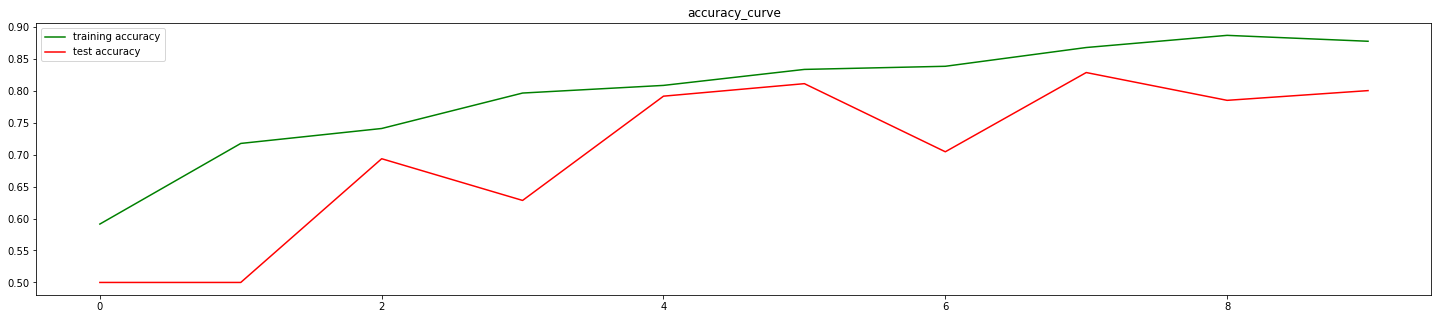

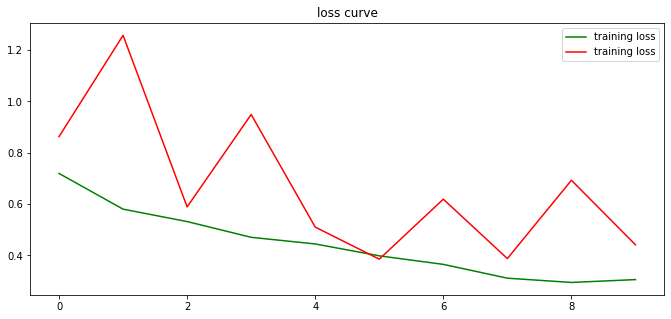

In [49]:
plot_model_performance(history, 10)